# Analysis of St. Louis Crime Data

## DATA620 Project 2

### Bryant Chang, Thomas Detzel, Erik Nylander

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

## Introduction

In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual. The data is available at http://moreno.ss.uci.edu/data.html#crime in compressed format. We have uploaded the data to our groups GitHub to allow for easier access to the files that we used.

In [3]:
# loading crime data
data_crime = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/out.moreno_crime_crime"
crime = pd.read_csv(data_crime, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])
# loading relationship data
data_rel = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/rel.moreno_crime_crime.person.role"
crime['Relationship'] = pd.read_csv(data_rel, header=None)

crime.head()

,Person,Crime,Relationship
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


In [4]:
# Total number of people
len(crime.Person.unique())

829

In [5]:
# Total number of crimes
len(crime.Crime.unique())

551

In [6]:
# Count of how many crimes each person was involved in 
crime.Person.value_counts().head()

815    25
2      22
425    18
220    17
56     14
Name: Person, dtype: int64

In [7]:
# adding count 
crime['Count'] = crime.groupby(['Person'])['Crime'].transform('count')
crime.head()

,Person,Crime,Relationship,Count
0,1,1,Suspect,4
1,1,2,Victim,4
2,1,3,Victim,4
3,1,4,Suspect,4
4,2,5,Victim,22


In [8]:
# loading name data
data_names = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.name'
names = pd.read_csv(data_names, sep='\t', header=None)

# loading sex data
data_sex = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.sex'
names['Sex'] = pd.read_csv(data_sex, header=None)
names.ix[names.Sex == 1, 'Sex'] = 'M'
names.ix[names.Sex == 0, 'Sex'] = 'F'

# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    crime.ix[crime.Person == i+1, 'Sex'] = names.iloc[i][1]
    crime.ix[crime.Person == i+1, 'Person'] = names.iloc[i][0]
    
crime.head()

,Person,Crime,Relationship,Count,Sex
0,AbelDennis,1,Suspect,4,M
1,AbelDennis,2,Victim,4,M
2,AbelDennis,3,Victim,4,M
3,AbelDennis,4,Suspect,4,M
4,AbramsChad,5,Victim,22,M


In [9]:
# Create graph
G = nx.Graph()
G = nx.from_pandas_dataframe(crime, 'Person', 'Crime', ['Relationship', 'Count', 'Sex'])

# a bit of info about the graph
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


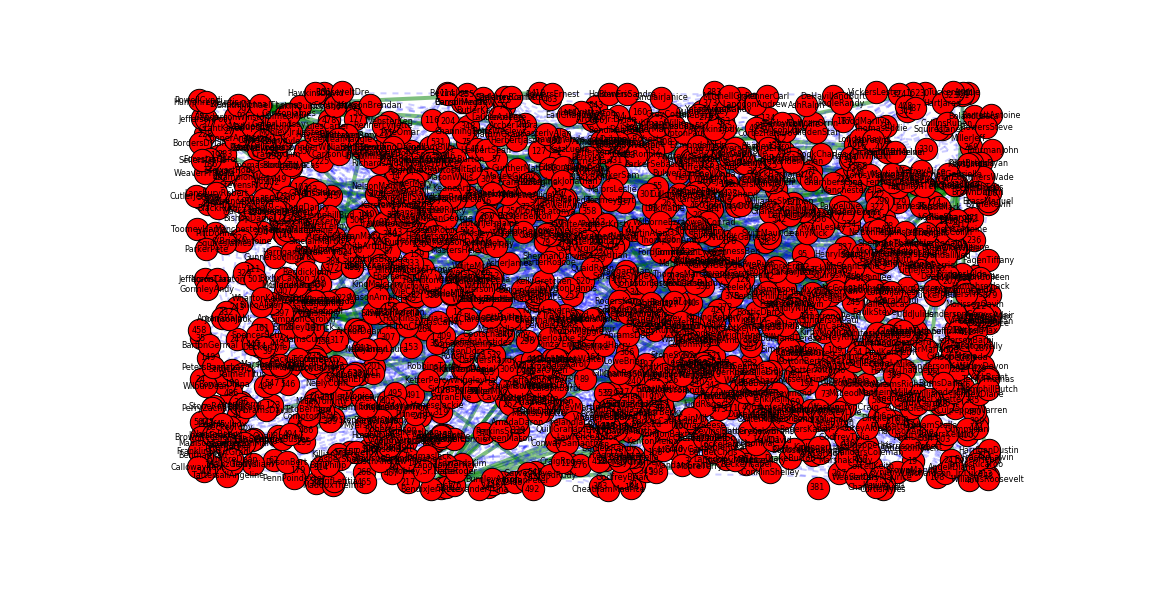

In [10]:
## plot the overall network
pos=nx.random_layout(G) # positions for all nodes

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] > 10]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] <= 10]

# nodes
nx.draw_networkx_nodes(G,pos,node_size=500)
# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='g',style='solid')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [22]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G)

# Degree centrality
deg_cen = nx.degree_centrality(G)

# Closeness centrality
clo_cen = nx.closeness_centrality(G)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G)

## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [23]:
cent_measures

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,WillisJenny,0.371301340152,47,0.10459398284,110,0.414920959003,WillisJenny,0.0181290790428
1,110,0.323802413821,SlatteryMaurice,0.10430116125,KatzLuella,0.414200419934,AbramsChad,0.0159535895577
2,SlatteryMaurice,0.254167041696,160,0.104197650534,SteinerCatherine,0.247706311047,110,0.0130529369108
3,23,0.252747859036,WillisJenny,0.104075584259,95,0.233381396842,KatzLuella,0.0130529369108
4,160,0.240850998043,23,0.10406620639,SmithMichaelThomas,0.220285657781,DicksonCarter,0.0123277737491
5,47,0.218627557343,AbramsChad,0.102962178704,417,0.183387969713,153,0.0108774474257
6,AbramsChad,0.189192601022,SteinerCatherine,0.102070416131,419,0.153482741794,BendixJerryLee,0.010152284264
7,46,0.178797977496,HemphillBud,0.101675038165,43,0.149970388001,14,0.00942712110225
8,14,0.168593116917,KarstenMae,0.101639246548,JohnstonJustin,0.142369334492,43,0.00942712110225
9,SteinerCatherine,0.156776034373,14,0.101416118592,MitchellGrant,0.138807303369,95,0.00942712110225


In [11]:
nx.is_connected(G), nx.is_bipartite(G)

(False, True)

In [20]:
# We have 20 subgraphs however one of them is a good size to work with.
subG = list(nx.connected_component_subgraphs(G))
print 'Nodes    Edges'
print '--------------'
for g in subG:
    print '%4d     %4d' %(len(g.nodes()), len(g.edges()))

Nodes    Edges
--------------
1263     1377
  30       30
  18       17
  13       12
   3        2
   2        1
   2        1
   6        5
   9        8
   2        1
   4        3
   5        4
   7        6
   2        1
   2        1
   3        2
   3        2
   2        1
   2        1
   2        1


In [21]:
C = subG[0]

In [22]:
## this is the more common way to do the same; women already are the top nodes, clubs on bottom
person, crime = nx.bipartite.sets(C)

### It's Still a Hairball

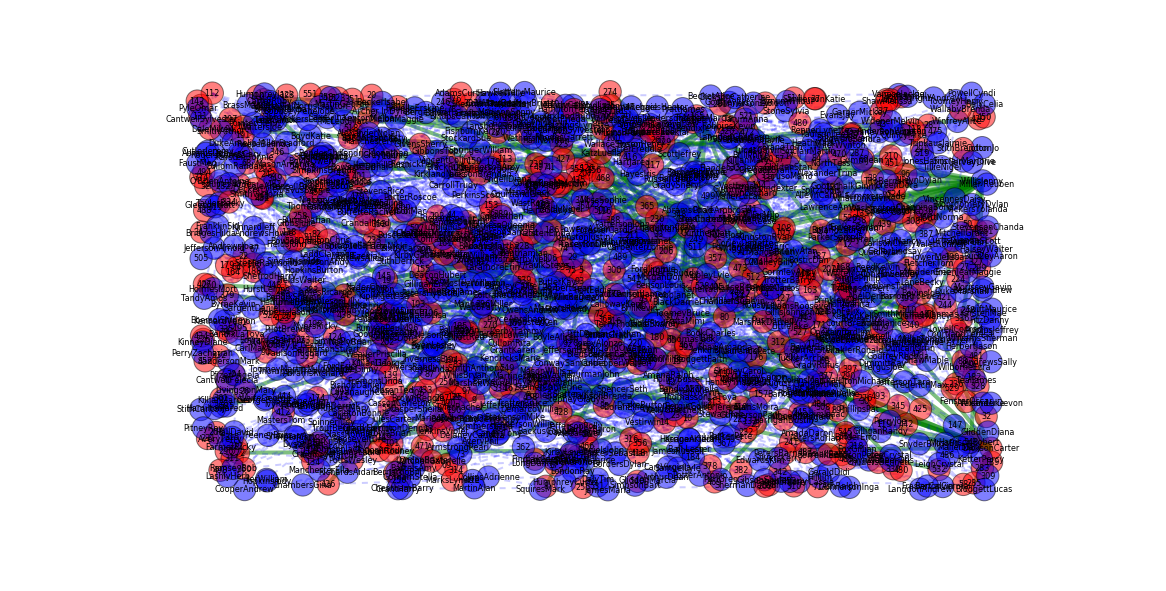

In [32]:
## plot the overall network

colors=[]
for n in C.degree().keys():
    if n in C.degree(person).keys():
        colors.append('b')
    else:
        colors.append('r')
        
pos=nx.random_layout(C) # positions for all nodes

elarge=[(u,v) for (u,v,d) in C.edges(data=True) if d['Count'] > 10]
esmall=[(u,v) for (u,v,d) in C.edges(data=True) if d['Count'] <= 10]

# nodes
nx.draw_networkx_nodes(C,pos,node_size=500, node_color=colors, alpha = .5)
# edges
nx.draw_networkx_edges(C,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='g',style='solid')
nx.draw_networkx_edges(C,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(C,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

# Bipartite Projection Person

In [31]:
# project bipartite graph onto person nodes
# now the degrees are their connections with other people
# based on involvment in the same crime events
# reverse-sort the list

PC = nx.bipartite.weighted_projected_graph(C, person)

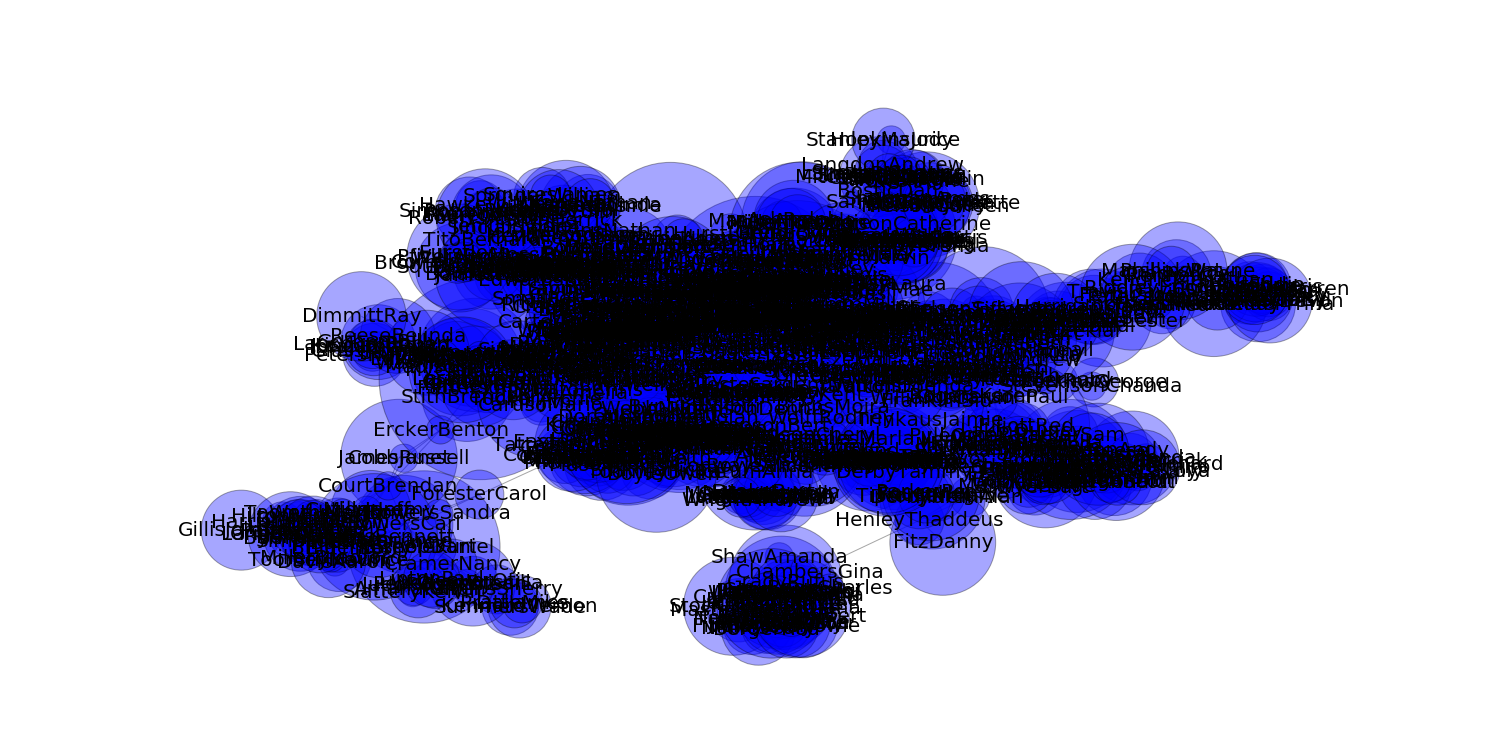

In [33]:
## plot the bipartite projection onto persons
# Still a hairball but some are much larger than others

d = nx.degree(PC)
nx.draw(PC, node_size=[v*800 for v in d.values()], with_labels=True, node_color='b', alpha=.35, font_size=20)

### x.x Island Analysis -- Persons

In [34]:
## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [42]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
islands = island_method(PC, iterations = 4)
print ''
print 'Depth  Person  Groups'
print '---------------------'
for island in islands:
    print(' %d      %2d      %d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Depth  Person  Groups
---------------------
 1      89      27
 2      28      12
 3      15      7
 4       6      3


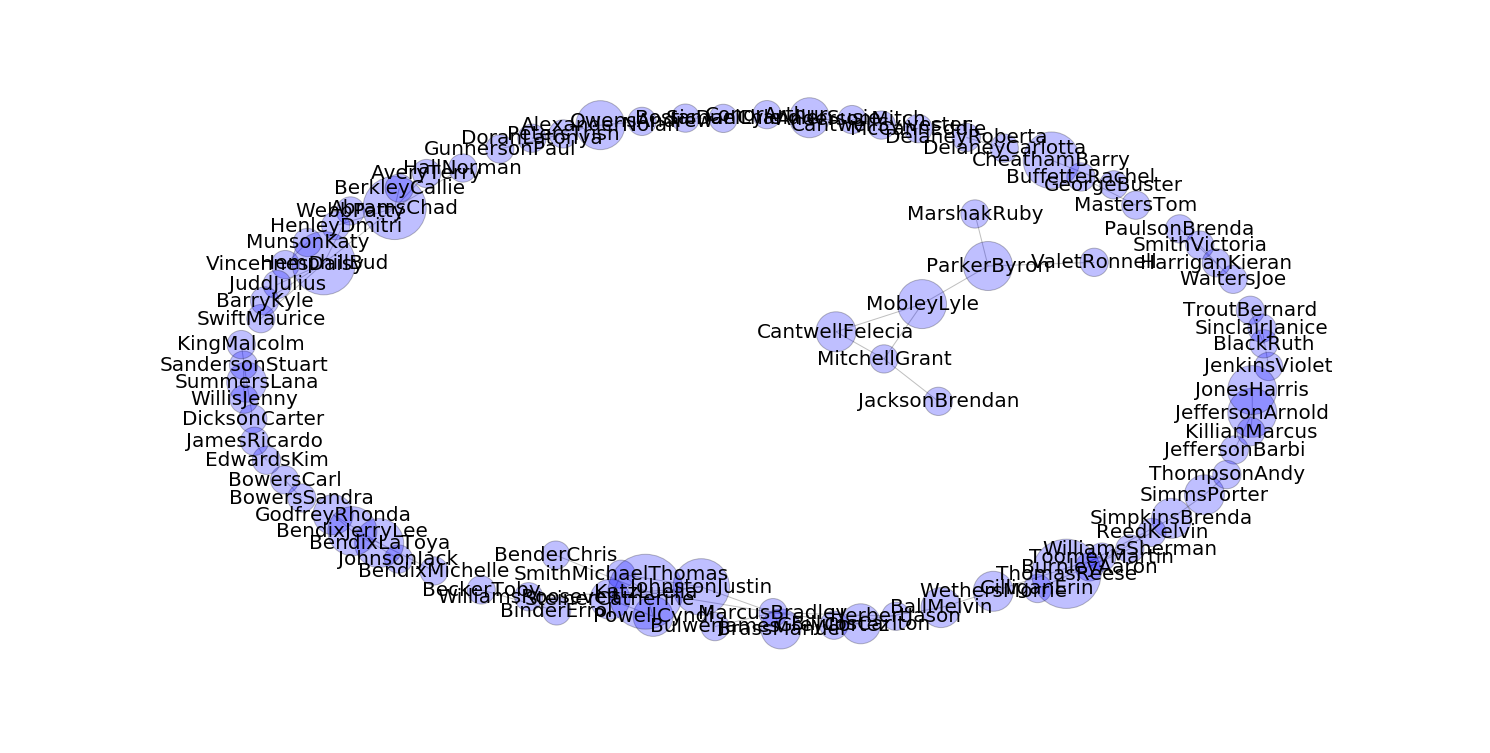

In [43]:
## Plotting the two graphs created by the island analysis

wc = trim_edges(PC, 1)
dwc = wc.degree()
nx.draw(wc, node_size=[v*800 for v in dwc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

# Bipartite Projection Crimes

In [45]:
# project bipartite graph onto crime nodes
# now the degrees are their connections with other crimes
# based on involvment by the same persons

CC = nx.bipartite.weighted_projected_graph(C, crime)

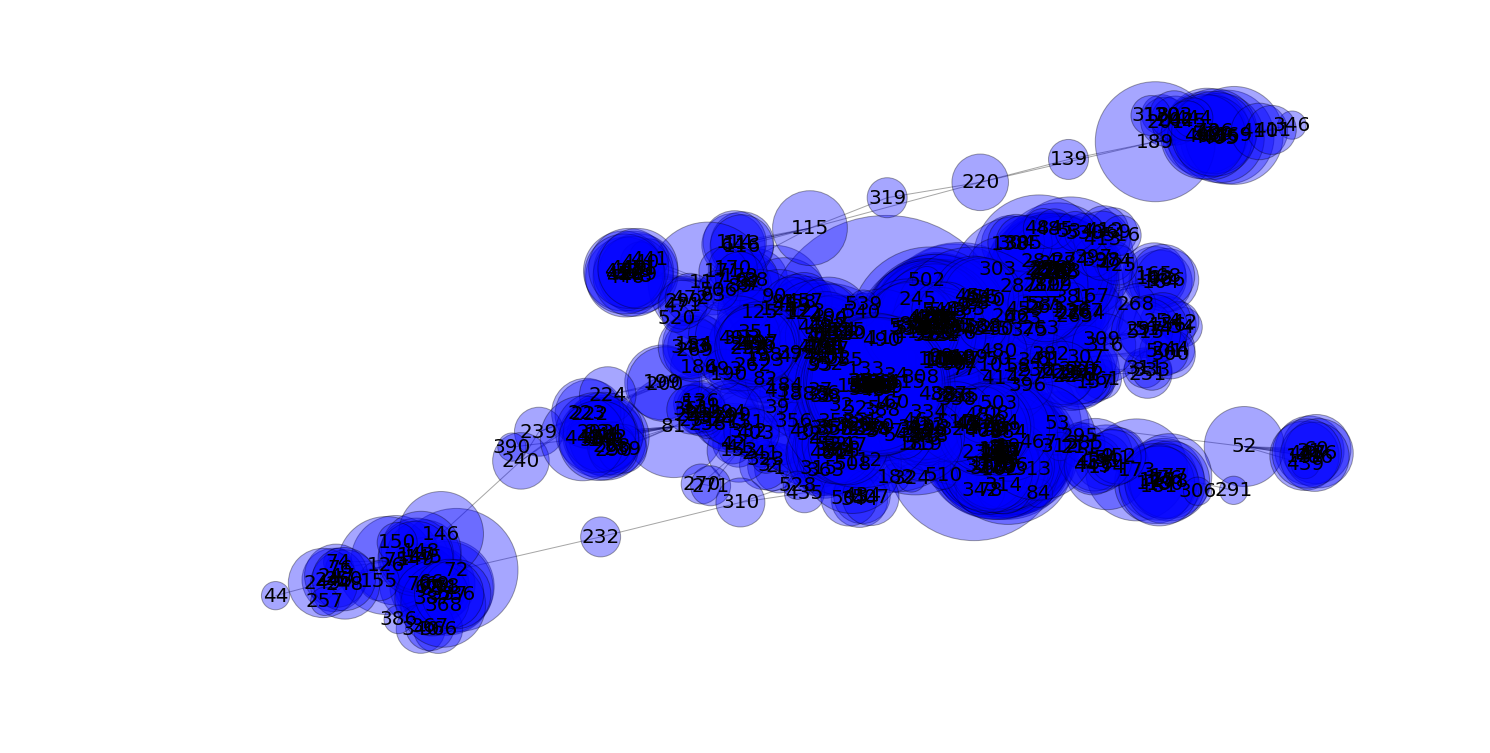

In [46]:
## plot the bipartite projection onto persons
# Still a hairball but some are much larger than others

d = nx.degree(CC)
nx.draw(CC, node_size=[v*800 for v in d.values()], with_labels=True, node_color='b', alpha=.35, font_size=20)

## x.x Island Analysis - Crimes

In [51]:
## Running the Island Analysis on the graph. Will thow an error if the island_method is called with too many steps
islands = island_method(CC, iterations = 2)
print ''
print 'Depth  Crime  Groups'
print '---------------------'
for island in islands:
    print(' %d      %2d      %d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))


Depth  Crime  Groups
---------------------
 1      117      35
 2      10      3


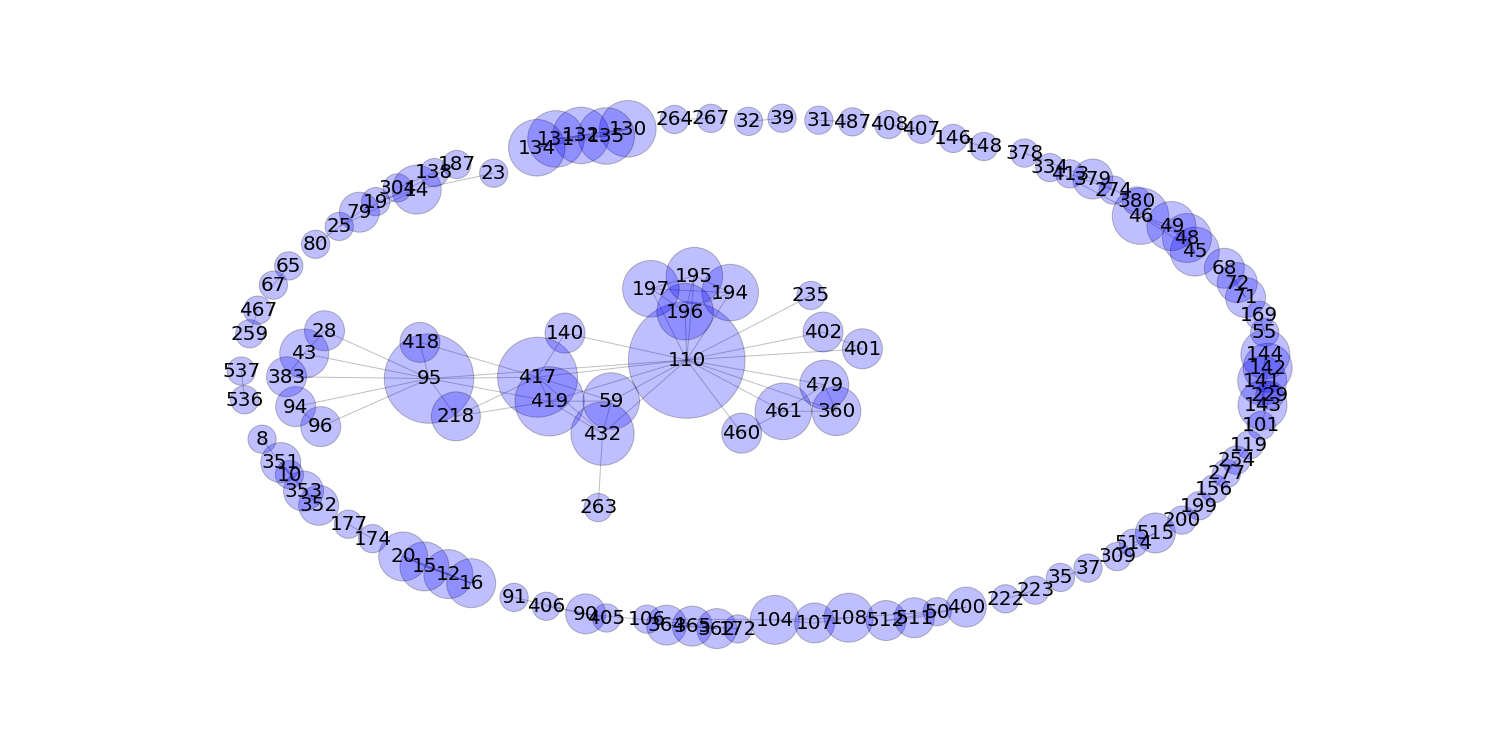

In [52]:
## Plotting the two graphs created by the island analysis

wc = trim_edges(CC, 1)
dwc = wc.degree()
nx.draw(wc, node_size=[v*800 for v in dwc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)